# get_unitids by Adam Hearn

## A Python Module to Imputate IPEDS UnitID Numbers from Non-Matching Institution Names

Have you ever worked with institutional data from multiple sources? If so, one of them is likmayely IPEDS which of course involves the infamous `unitid` variable. The secondary source, on the other hand, may only have the institution's name and no `unitid`. In this case, to join the datasets, you would need to merge on institution name and fill in the rest of the unitids manually to retrieve the IPEDS data.  

Anyone who has worked with IPEDS data would know that not all institution names perfectly line up across multiple sources. For example, Tulane University is named as Tulane University of Louisiana in the IPEDS universe. In this case of conflicting names, there would be an imperfect merge requiring you to manually enter Tulane's unitid number.

In my background, I've run into this issue several times and has gotten to the point where it would be a better use of time to create a module to automate this step rather than filling out unitids manually. That said, I've developed the Python module `unitids`. I'm making this process open-source so other higher-ed researchers can benefit, too. 

This module, available in the `pip` library, uses a cosine similarity text-analyis metric to merge partial or "non-matching" institution names with an IPEDS master file including all institutions in the IPEDS universe since 2004 and their unitid numbers.

The process works by passing a DataFrame of institutions of which you want to get their unitids into the `get_unitids` function. From there, the function populates a sparse matrix and generates a cosine-similarity metric for each insitution you passed and each institution in the IPEDS universe.

It will then return two DataFrame objects: the first DataFrame will include your original data and the unitid numbers of the institutions in the dataset, along with a "match score" (displayed on a scale of 0-100). 

The second DataFrame includes information on the institutions that were not a perfect match, alongside their top-5 closes matches so you can make adjustments as necessary.

## Example

Take, for example, the data present in [this article](https://www.forbes.com/sites/schifrin/2019/11/27/dawn-of-the-dead-for-hundreds-of-the-nations-private-colleges-its-merge-or-perish/#77a18358770d). The cleaned data is available on my Github [here](https://raw.githubusercontent.com/ahearn15/get_unitids/master/example_dta.csv).

Suppose we want to see the relationshpi between Forbes' Financial GPA and endowment, as reported to IPEDS. I've included a sample dataset of FY2018 endowment for all institutions in the IPEDS universe [here](https://raw.githubusercontent.com/ahearn15/get_unitids/master/ipeds_example.csv).

In [1]:
# Import necessary modules (no unitid, yet)
import pandas as pd
import numpy as np

# First we read in the Forbes data:
url = 'https://raw.githubusercontent.com/ahearn15/get_unitids/master/example_dta.csv'
forbes = pd.read_csv(url)
forbes.head(5)

,College,State,Financial GPA,Financial Grade
0,Stanford University,CA,4.5,A+
1,Massachusetts Institute of Technology,MA,4.5,A+
2,University of Notre Dame,IN,4.5,A+
3,Princeton University,NJ,4.5,A+
4,University of Pennsylvania,PA,4.5,A+


In [2]:
# Now we read in the IPEDS data
url = 'https://raw.githubusercontent.com/ahearn15/get_unitids/master/ipeds_example.csv'
ipeds = pd.read_csv(url).drop(columns = 'Unnamed: 0')
ipeds.head(5)

,unitid,institution,endowment
0,177834,A T Still University of Health Sciences,32420.0
1,180203,Aaniiih Nakoda College,9212.0
2,491464,ABC Adult School,NaN
3,459523,ABC Beauty Academy,NaN
4,485500,ABCO Technology,NaN


In [3]:
# Now we merge together
forbes = forbes.rename(columns = {'College' : 'institution'}) # need to rename for merge
merged = pd.merge(forbes, ipeds, on = 'institution', how = "left")
merged.head(5)

,institution,State,Financial GPA,Financial Grade,unitid,endowment
0,Stanford University,CA,4.5,A+,243744.0,1496715.0
1,Massachusetts Institute of Technology,MA,4.5,A+,166683.0,1454419.0
2,University of Notre Dame,IN,4.5,A+,152080.0,837184.0
3,Princeton University,NJ,4.5,A+,186131.0,3053449.0
4,University of Pennsylvania,PA,4.5,A+,215062.0,562092.0


In [4]:
# How many did not merge?
merged['unitid'].isna().sum()

40

If we merge our Forbes data with this 2018 list of IPEDS institutions, we get a successful merge rate of 95.7% (892 of 932 institutions). However, we still have 40 unitids we need to manually encode, taking up 40 lines of code and tedious trips to the IPEDS Data Center. What if we used the new `get_unitids` function though?

## get_unitids

In [5]:
# Installing the module
!pip install unitids==0.0.92

# Import required functions
import numpy as np
import pandas as pd
from unitids import unitids

#For viewing nonmatches
pd.set_option('display.max_rows', 100)

### Running the algorithm

The first argument we pass to the function, `forbes`, is our original dataset with the institutions of which we want to retreive unitids. The second argument, `stateFlag`, is an indicator of whether or not we have state abbreviations in our data. This makes the merge much faster and much cleaner, which I'll get to shortly.

The funciton returns two DataFrames: `merged` is our original dataset with the fancy new unitids. The second dataframe returned, `nonmatches`, allows us to investigate the institutions that did not perfectly merge and make adjustments as necessary. Now we're ready to call the function!

Sidenote: For the algorithm to run error-free, the institution name variable must be listed the first column and the state variable (if available) must be in the second column.

In [7]:
# Calling the function
forbes_unitids, nonmatches = unitids.get_unitids(forbes, stateFlag = True)

#viewing the new data
forbes_unitids.head(5)

,institution,State,Financial GPA,Financial Grade,unitid,match
0,Stanford University,CA,4.5,A+,243744.0,100.0
1,Massachusetts Institute of Technology,MA,4.5,A+,166683.0,100.0
2,University of Notre Dame,IN,4.5,A+,152080.0,100.0
3,Princeton University,NJ,4.5,A+,186131.0,100.0
4,University of Pennsylvania,PA,4.5,A+,215062.0,100.0


In [8]:
# How many did not merge?
forbes_unitids['unitid'].isna().sum()

0

100% of the institutions merged! We have significantly fewer unitids we need to fill in ourselves. We can investigate the institutions that were not perfect merges by viewing the second DataFrame, `nonmatches`:

In [9]:
nonmatches

similarity  \
institution                                        match Top 5                                                            
Baptist College of Health Sciences  (TN)           1.0   Baptist Memorial College of Health Sciences (TN)      0.925820   
                                                   2.0   Huntington College of Health Sciences (TN)            0.833333   
                                                   3.0   Huntington University of Health Sciences (TN)         0.666667   
                                                   4.0   American Baptist College (TN)                         0.612372   
                                                   5.0   Fayetteville College of Cosmetology Arts and Sc...    0.577350   
Calumet College of St. Joseph  (IN)                1.0   Calumet College of Saint Joseph (IN)                  0.833333   
                                                   2.0   American College of Education (IN)                    0.547723   
                                                         Lincoln College of Technology (IN)                    0.547723   
                                                   3.0   College of Court Reporting Inc (IN)                   0.500000   
                                                         PJ's College of Cosmetology (IN)                      0.500000   
Franklin & Marshall College  (PA)                  1.0   Franklin and Marshall College (PA)                    0.894427   
                                                   2.0   Harcum College (PA)                                   0.577350   
                                                         Juniata College (PA)                                  0.577350   
                                                         Rosemont College (PA)                                 0.577350   
                                                         Wilson College (PA)                                   0.577350   
Golden Gate University  (CA)                       1.0   Golden Gate University-San Francisco (CA)             0.816497   
                                                   2.0   Ashford University (CA)                               0.577350   
                                                         Saybrook University (CA)                              0.577350   
                                                         Simpson University (CA)                               0.577350   
                                                         Stanbridge University (CA)                            0.577350   
Hobart and William Smith Colleges  (NY)            1.0   Hobart William Smith Colleges (NY)                    0.912871   
                                                   2.0   The Sage Colleges (NY)                                0.408248   
                                                   3.0   Berk Trade and Business School (NY)                   0.333333   
                                                         Bryant and Stratton College-Lackawanna (NY)           0.333333   
                                                         Elim Bible Institute and College (NY)                 0.333333   
Jefferson (Philadelphia University + Thomas Jef... 1.0   Thomas Jefferson University (PA)                      0.904534   
                                                   2.0   Philadelphia Biblical University-Langhorne (PA)       0.539360   
                                                   3.0   Bucknell University (PA)                              0.522233   
                                                         Lehigh University (PA)                                0.522233   
                                                         Widener University (PA)                               0.522233   
LeMoyne-Owen College  (TN)                         1.0   Le Moyne-Owen College (TN)                            0.670820   
                                                  

For example, we can see that Franklin & Marshall College merged successfully with its official name in the IPEDS universe, "Franklin and Marshall College". Also, Tulane University merged successfully with "Tulane University of Louisiana", Hobart and William Smith Colleges merged with "Hobart William Smith Colleges", etc. 

Further, the algorithm accounts for institutions with changed names. For example, Dordt did not merge in the original dataset (since Forbes called it "Dordt College" and it's official IPEDS name is "Dordt University". The same issue is raised with Calvin College (now Calvin Univeristy). The IPEDS dictionary nested in the algorithm accounts for these historical name-changes. That is why there are only 15 non-perfect matches with this algorithm as opposed to 40 merging the "old fashioned way".

However, this wasn't perfect: Saint John's University (MN) merged with Saint Mary's University of Minnesota instead, so we will need to correct that ourselves. We can find the correct unitid in the `nonmatches` dataframe above. Still, one line of code compared to 40 is a big time-saver!

In [10]:
# Replaces unitid for Saint John's University (MN) only
# For Stata folks, same as replace unitid = 174792 if institution == "Saint John's University (MN)"
forbes_unitids['untid'] = np.where(forbes_unitids['institution'] == "Saint John's University (MN)", 174792, forbes_unitids['unitid'])

Running this algorithm on this dataset as opposed to merging on institution-name gives us an accuracy of 99.9% (931 of 932 institutions), up from 95.7% earlier (892 of 932 institutions). It's a marginal improvement, but a big time-saver.

To answer our original research question of how endowment impacts Forbes' "Financial GPA" measure, we can merge in our IPEDS data cleanly here.

In [11]:
dta = pd.merge(forbes_unitids, ipeds, on = 'unitid', how = 'left')
dta = dta.drop(columns = "institution_y") # no need for duplicate column
dta = dta.rename(columns = {"institution_x" : "institution"}) # renaming
dta.head(5)

,institution,State,Financial GPA,Financial Grade,unitid,match,untid,endowment
0,Stanford University,CA,4.5,A+,243744.0,100.0,243744.0,1496715.0
1,Massachusetts Institute of Technology,MA,4.5,A+,166683.0,100.0,166683.0,1454419.0
2,University of Notre Dame,IN,4.5,A+,152080.0,100.0,152080.0,837184.0
3,Princeton University,NJ,4.5,A+,186131.0,100.0,186131.0,3053449.0
4,University of Pennsylvania,PA,4.5,A+,215062.0,100.0,215062.0,562092.0


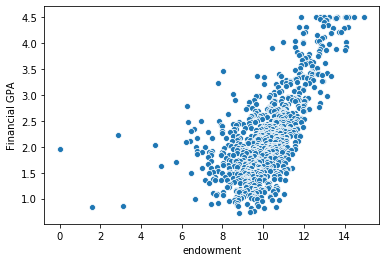

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#using logged endowment, as any sane econometrician would
sns.scatterplot(x=np.log(dta["endowment"]), y=dta["Financial GPA"]) 

Seems like endowment plays a pretty significant role in Forbes' grading of Financial GPA!

### What if we have no state data?

Note that the original merge went very well mostly due to us having access to state codes in our secondary dataset. Suppose our Forbes data did not have state codes, in which case the merge would have gone like this:

In [14]:
forbes_unitids, nonmatches = unitids.get_unitids(forbes, stateFlag = False)

Running the algorithm with `stateFlag = False` takes significantly longer, considering we can no longer "throw out" institutions that do not match the same state. Instead, the algorithm must cross-check institutions across all states, not just the ones within states like it did when `stateFlag` was set to `True`.

In [15]:
nonmatches

similarity  \
institution                                        match Top 5                                                            
Baptist College of Health Sciences                 1.0   Baptist Memorial College of Health Sciences (TN)      0.912871   
                                                   2.0   Australasian College of Health Sciences (OR)          0.800000   
                                                         Bryan College of Health Sciences (NE)                 0.800000   
                                                         Jefferson College of Health Sciences (VA)             0.800000   
                                                         Sentara College of Health Sciences (VA)               0.800000   
Calumet College of St. Joseph                      1.0   College of St Joseph (VT)                             0.894427   
                                                   2.0   Calumet College of Saint Joseph (IN)                  0.800000   
                                                         College of Mount St Joseph (OH)                       0.800000   
                                                         College of Mount St. Joseph (OH)                      0.800000   
                                                   3.0   St. Joseph's College of Nursing (NY)                  0.730297   
Franklin & Marshall College                        1.0   Franklin and Marshall College (PA)                    0.866025   
                                                   2.0   Franklin College (IN)                                 0.816497   
                                                         Franklin College (TX)                                 0.816497   
                                                   3.0   Franklin Pierce College (NH)                          0.666667   
                                                   4.0   Marshall Community and Technical College (WV)         0.516398   
Golden Gate University                             1.0   Golden Gate University-San Francisco (CA)             0.774597   
                                                   2.0   Chapman University-University College (CA)            0.471405   
                                                   3.0   Indiana University-Purdue University-Indianapol...    0.436436   
                                                         University of Illinois University Administratio...    0.436436   
                                                         University of Maryland-University College (MD)        0.436436   
Hobart and William Smith Colleges                  1.0   Hobart William Smith Colleges (NY)                    0.894427   
                                                   2.0   College of William and Mary (VA)                      0.400000   
                                                   3.0   Texas Barber Colleges and Hairstyling Schools (TX)    0.365148   
                                                   4.0   Richard Bland College of William and Mary (VA)        0.338062   
                                                         State Board for Community and Junior Colleges (MS)    0.338062   
Jefferson (Philadelphia University + Thomas Jef... 1.0   Thomas Jefferson University (PA)                      0.912871   
                                                   2.0   Thomas University (GA)                                0.670820   
                                                   3.0   Saint Thomas University (FL)                          0.547723   
                                                         St Thomas University (FL)                             0.547723   
                                                         St. Thomas University (FL)                            0.547723   
LeMoyne-Owen College                               1.0   Le Moyne-Owen College (TN)                            0.577350   
                                                  

There were still 913 perfect merges, but the accuracy on imputing the remaining 19 unitids is not as high: we only got 13 of these (accuracy of 68% within the nonperfect matches, 99.4% for the whole dataset). 

For example, Calumet College of St. Joseph merged with College of St. Joseph (VT) when it should have merged with Calumet College of Saint Joseph (IN). Plus, we must now account for institutions with the same name, such as Wheaton College (IL and MA). Still, not terrible, but it is alwasy a good idea to check for what unitids were imputed. Luckily this module makes it easy to do that. 

# Conclusion

I hope this can be a valuable tool for higher ed researchers out there. While this is currently only available in Python, I hope to get around to making it available on Stata and R soon. Please leave any feedback or bug reports on my GitHub repository [here](www.github.com/ahearn15/get_unitds). 